In [1]:
#import libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Load cleaned data
df = pd.read_csv('amazon_sales_cleaned.csv')
df['order_date'] = pd.to_datetime(df['order_date'])


# 1. Descriptive Statistics
# ------------------------------
print("Descriptive statistics for numeric columns:\n")
display(df.describe())

Descriptive statistics for numeric columns:



,order_id,order_date,product_id,price,discount_percent,quantity_sold,rating,review_count,discounted_price,total_revenue,year,month,day,day_of_week
count,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0000,50000.000000,50000.000000
mean,25000.500000,2022-12-31 10:47:16.800000256,2986.848740,252.507260,13.340700,2.999400,2.996316,249.329280,218.886566,654.978488,2022.501480,6.5044,15.790820,3.018120
min,1.000000,2022-01-01 00:00:00,1000.000000,5.010000,0.000000,1.000000,1.000000,0.000000,3.530000,3.840000,2022.000000,1.0000,1.000000,0.000000
25%,12500.750000,2022-07-02 00:00:00,1983.000000,127.840000,5.000000,2.000000,2.000000,125.000000,109.680000,240.320000,2022.000000,4.0000,8.000000,1.000000
50%,25000.500000,2023-01-02 00:00:00,2983.000000,252.970000,10.000000,3.000000,3.000000,250.000000,215.805000,505.410000,2023.000000,7.0000,16.000000,3.000000
75%,37500.250000,2023-07-02 00:00:00,3989.000000,376.335000,20.000000,4.000000,4.000000,374.000000,322.702500,968.970000,2023.000000,9.0000,23.000000,5.000000
max,50000.000000,2023-12-31 00:00:00,4999.000000,499.990000,30.000000,5.000000,5.000000,499.000000,499.910000,2061.945000,2023.000000,12.0000,31.000000,6.000000
std,14433.901067,NaN,1156.374535,143.025544,9.850694,1.415401,1.154295,144.251981,127.317681,519.356606,0.500003,3.4360,8.799767,1.999068


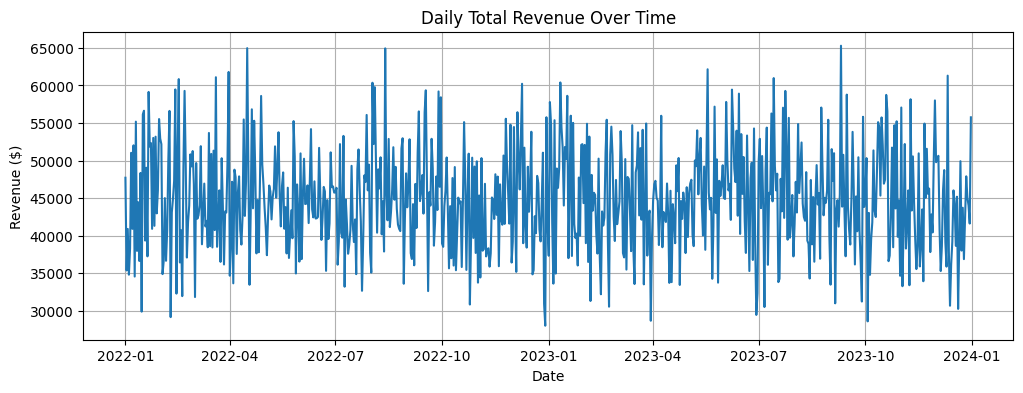

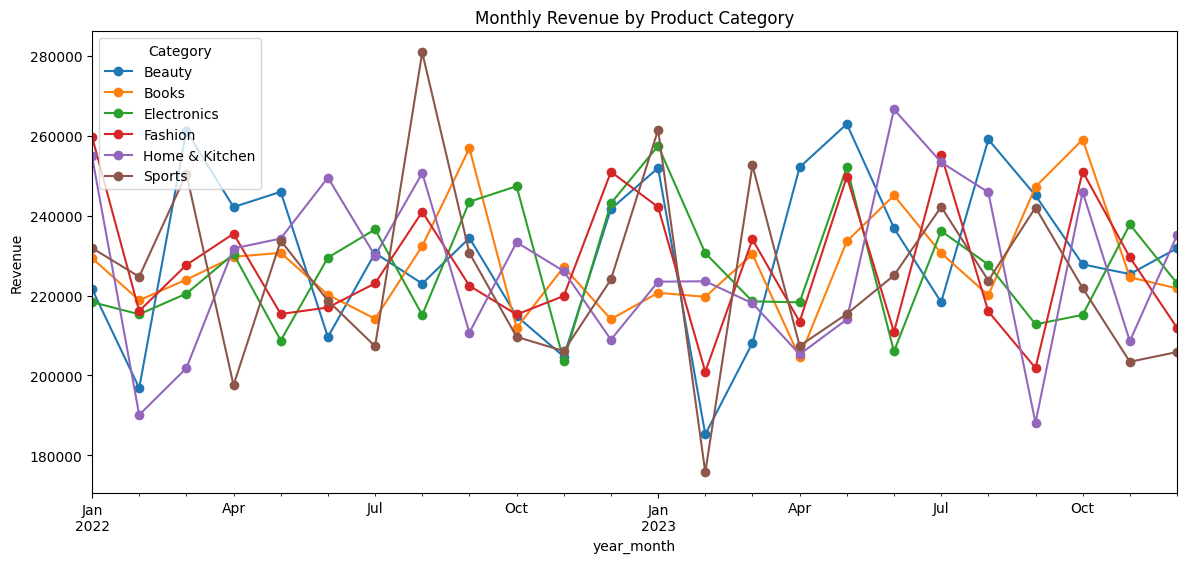

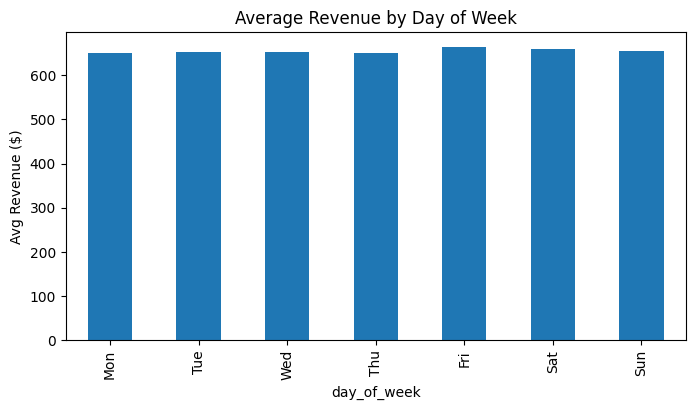

In [2]:
# 2. Temporal Trends 

# Daily total revenue
daily_revenue = df.groupby('order_date')['total_revenue'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(daily_revenue['order_date'], daily_revenue['total_revenue'])
plt.title('Daily Total Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue ($)')
plt.grid(True)
plt.show()

# Monthly aggregated sales by category
df['year_month'] = df['order_date'].dt.to_period('M')
monthly_category = df.groupby(['year_month', 'product_category'])['total_revenue'].sum().unstack().fillna(0)
monthly_category.plot(figsize=(14,6), marker='o')
plt.title('Monthly Revenue by Product Category')
plt.ylabel('Revenue')
plt.legend(title='Category')
plt.show()

# Day-of-week analysis
dow_revenue = df.groupby('day_of_week')['total_revenue'].mean()
plt.figure(figsize=(8,4))
dow_revenue.plot(kind='bar')
plt.xticks(ticks=range(7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
plt.title('Average Revenue by Day of Week')
plt.ylabel('Avg Revenue ($)')
plt.show()




Regional Sales Summary:
                  total_revenue  quantity_sold  rating  discount_percent
customer_region                                                        
Middle East         8271355.28          37694    3.02             13.23
North America       8247662.50          37534    3.00             13.30
Asia                8146249.04          37440    3.00             13.48
Europe              8083657.56          37302    2.97             13.35


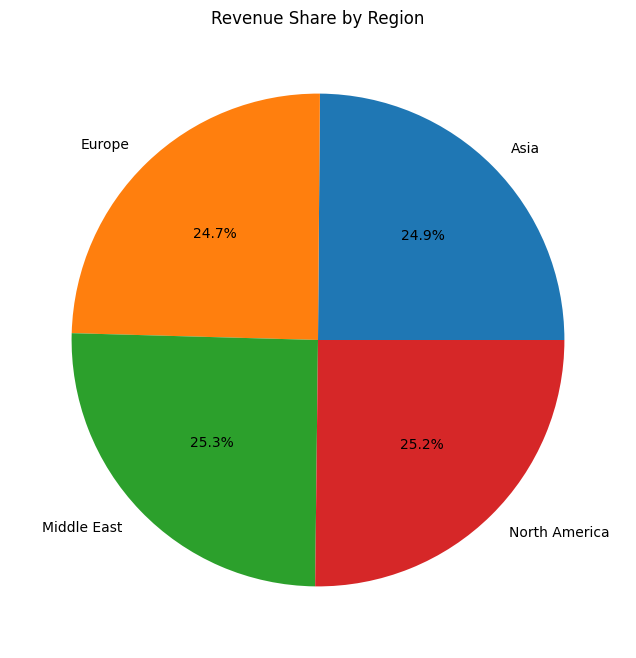

In [3]:
# 3. Regional Comparisons 

region_stats = df.groupby('customer_region').agg({
    'total_revenue': 'sum',
    'quantity_sold': 'sum',
    'rating': 'mean',
    'discount_percent': 'mean'
}).round(2).sort_values('total_revenue', ascending=False)
print("\nRegional Sales Summary:\n", region_stats)

# Revenue share by region
plt.figure(figsize=(8,8))
df.groupby('customer_region')['total_revenue'].sum().plot(kind='pie', autopct='%1.1f%%')
plt.title('Revenue Share by Region')
plt.ylabel('')
plt.show()


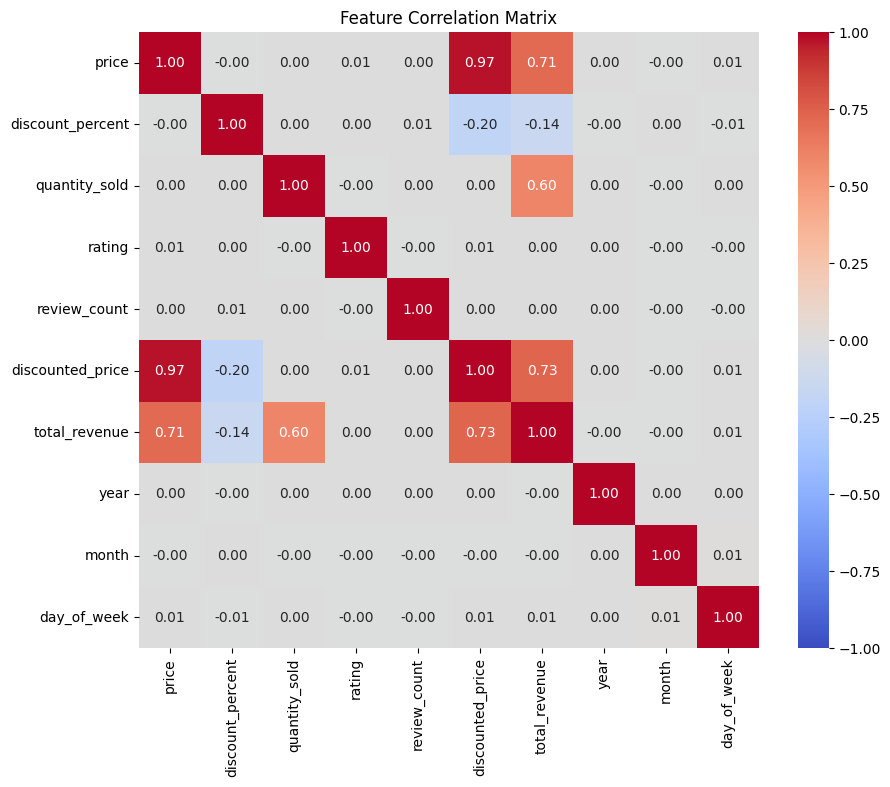

In [4]:
# 4. Correlation Analysis 

numeric_cols = ['price', 'discount_percent', 'quantity_sold', 'rating', 'review_count', 
                'discounted_price', 'total_revenue', 'year', 'month', 'day_of_week']
corr = df[numeric_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

# Observations: total_revenue strongly correlated with quantity_sold and price; rating weakly correlated with others.




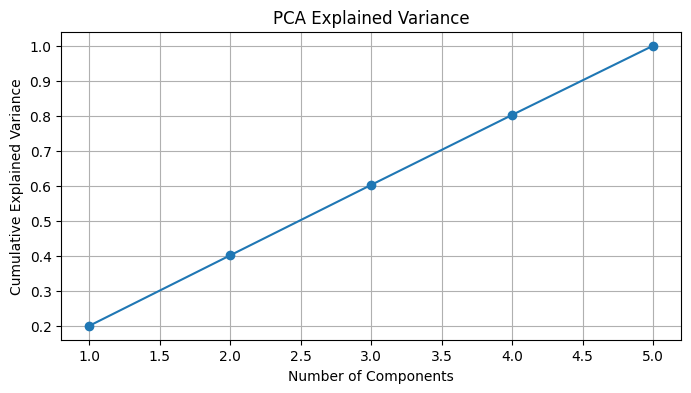

Explained variance ratio per PC: [0.2014724  0.20101306 0.20074991 0.19949622 0.19726842]


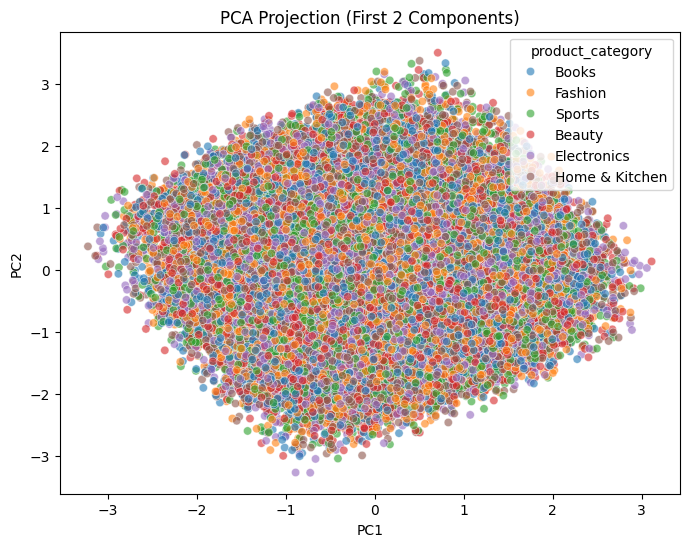

In [5]:
# 5. Dimensionality Reduction (PCA) 

# Scale numeric features for PCA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[['price', 'discount_percent', 'quantity_sold', 'rating', 'review_count']])

pca = PCA()
pca_result = pca.fit_transform(scaled_features)

# Explained variance
plt.figure(figsize=(8,4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()
print("Explained variance ratio per PC:", pca.explained_variance_ratio_)

# First two PCs
df['PC1'] = pca_result[:,0]
df['PC2'] = pca_result[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='product_category', data=df, alpha=0.6)
plt.title('PCA Projection (First 2 Components)')
plt.show()


In [ ]:
# 6. Clustering Analysis (K-Means) 

# Use scaled features for clustering
inertia = []
silhouette_scores = []
K_range = range(2,10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(scaled_features)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_features, labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()
# Choose k=3 (example) based on elbow and silhouette.

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(scaled_features)

# Profile clusters
cluster_profile = df.groupby('cluster')[['price','discount_percent','quantity_sold','rating','total_revenue']].mean()
print("\nCluster Profiles:\n", cluster_profile)

# Business interpretation: e.g., cluster 0 = high-price high-revenue, cluster 1 = low-price low-revenue, etc.



In [ ]:
# 7. Anomaly Detection (simple z-score on total_revenue) 

from scipy import stats
df['revenue_zscore'] = np.abs(stats.zscore(df['total_revenue']))
anomalies = df[df['revenue_zscore'] > 3]
print(f"Number of anomalous transactions (|z|>3): {len(anomalies)}")
print(anomalies[['order_id','total_revenue','product_category','customer_region']].head())
df.drop('revenue_zscore', axis=1, inplace=True)

In [ ]:
# 8. Business-Relevant Insights 

# 1. Best-selling categories by region
region_cat = df.groupby(['customer_region','product_category'])['quantity_sold'].sum().unstack()
print("\nBest-selling category per region:\n", region_cat.idxmax(axis=1))

# 2. Discount effectiveness: correlation between discount and quantity
disc_qty_corr = df.groupby('product_category')[['discount_percent','quantity_sold']].corr().iloc[0::2,-1]
print("\nDiscount-Quantity correlation by category:\n", disc_qty_corr)

# 3. Rating distribution
plt.figure(figsize=(8,4))
sns.histplot(df['rating'], bins=20, kde=True)
plt.title('Rating Distribution')
plt.show()
